# SARSA with Gridworld

## Goal:

- Adapt from Monte Carlo
- SARSA

In [343]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Make Env

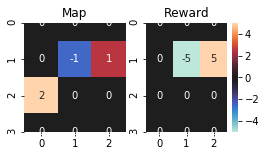

In [344]:
def make_env():
    env = rl.env.Gridworld(shape=(4, 3),
                           start=(2, 0),
                           goal=(1, 2),
                           move_reward=-1)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=20)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env


env = make_env()
env.reset()
env.render()

## Step 2: Define policy

SARSA with policy iteration (with only one-step policy evaluation) using moving average.

In [345]:
class SARSAPolicy(rl.policy.BasePolicy):

    def __init__(self, lr, discount_factor, observation_space, n_action):
        self.lr = lr
        self.discount_factor = discount_factor
        self.observation_space = observation_space
        self.n_action = n_action

        self.q = np.zeros(list(self.observation_space.high) +
                          [n_action], dtype=np.float64)  # (s0, s1, a)
        #print(list(self.observation_space.high) +[n_action])

    def step(self, state):
        # code here ...
        #print(self.q[tuple(state)])
        #if(tuple(state) == (2,0)): print(self.q[tuple(state)])
        return np.argmax(self.q[tuple(state)])

    def optimize_step(self, data):
        # code here ...
        s = data['s']
        a = data['a']
        r = data['r']
        ss = data['ss']
        aa = data['aa']
        s0 = (s[0],s[1],a)
        s1 = (ss[0],ss[1],aa)
        #print('hi')
        #print(s0,r,s1)
        #print(self.q[s0] + self.discount_factor*(r+self.q[s1]))
        self.q[s0] = self.q[s0] + self.discount_factor*(r+self.q[s1])
        #print(self.q)

## Step 3: Define an explorer

Create `OneStepExplorer` to use with SARSA. You could look at the `EpisodeExplorer` for inspirations.

The `OneStepExplorer` should run a given policy only for ONE step then return what it sees.

It should return something like this from its `step` method: 

```
{
    's': current state,
    'a': action,
    'r': reward,
    'ss': next state,
    'aa': next action,
    'done': is done?,
}
```

In [346]:
class OneStepExplorer(rl.explorer.BaseExplorer):
    """explore the environment only one-step then returns the experience immediately"""
    def __init__(self, n_max_interaction, env):
        super().__init__(env)
        self.n_max_interaction = n_max_interaction
        self.last_s = self.env.reset()
        self.n_interaction = 0
        self.n_ep = 0
        self.collect_reward = []
        self.stat = []
        
    def step(self, policy):
        if self.n_interaction >= self.n_max_interaction:
            #rint(self.last_s)
            self.n_interaction = 0
            self.collect_reward.clear()
            raise rl.exception.InteractionExceeded()
        self.n_interaction+=1
        self.n_ep+=1
        # code here
        s = np.array(self.last_s)
        action = policy.step(self.last_s)
        a = action
        ss, r, done ,infox = self.env.step(action)
        self.last_s = ss
        aa = policy.step(ss)
        info = {'s':s,'a':a,'r':r,'ss':ss,'aa':aa,'done':done}
        #print(temp)
        # data = the experience of the last step
        self.collect_reward.append(r)
        self.stat.append((self.n_interaction,np.sum(self.collect_reward)))
        if(done):
            self.collect_reward.clear()
            self.env.reset()
            return info
        return info
    def get_reward(self):
        return np.array(self.stat)

Test the explorer:

In [347]:
rl.util.set_seed(0)
explorer = OneStepExplorer(1, make_env())
explorer.step(rl.policy.RandomPolicy(n_action=4))

{'s': array([2, 0]),
 'a': 3,
 'r': -1,
 'ss': array([2, 1]),
 'aa': 3,
 'done': False}

Expected result: 

```
{'s': array([2, 0]),
 'a': 3,
 'r': -1,
 'ss': array([2, 1]),
 'aa': 3,
 'done': False}
```

Your result might vary, but the structure should be the same.

In [348]:
explorer.step(rl.policy.RandomPolicy(n_action=4))

InteractionExceeded: 

Expected result: `InteractionExceeded` exception raised.

## Running the algorithm

In [349]:
def run(policy, n_max_interaction):
    rl.util.set_seed(0) # predictable results
    env = make_env()
    env.reset()
    explorer = OneStepExplorer(n_max_interaction=n_max_interaction, env=env)
    while True:
        try:
            data = explorer.step(policy)
            #print(data)
            policy.optimize_step(data)  # not defined
        except rl.exception.InteractionExceeded:
            break
    #print(explorer.get_reward())
    reward = explorer.get_reward()
    df = pd.DataFrame(reward)
    df.columns = ['n_interaction', 'reward']
    print(df)
    #df.dropna()
    return df

     n_interaction  reward
0                1      -1
1                2      -2
2                3      -3
3                4      -4
4                5      -5
..             ...     ...
495            496      -2
496            497       2
497            498      -1
498            499      -2
499            500       2

[500 rows x 2 columns]
max: 2


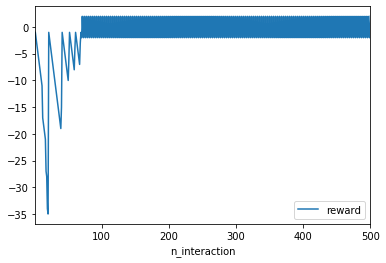

In [351]:
policy = SARSAPolicy(lr=0.1,
                     discount_factor=0.99,
                     observation_space=env.observation_space,
                     n_action=env.action_space.n)
stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Expected result: In our implementation, we could get ~2 reward under 500 iteractions.

# Q1: Even without an explicit exploration like epsilon greedy, SARSA seems to work! Why is that the case? What works as an "implicit" exploration?

Describe here ...
เพราะทำจำนวนรอบเยอะเมื่อเทียบกับ action ทั้งหมดที่จะเป็นไปได้ จึงสามารถทดลองทุกๆ action ที่เป็นไปได้

# Q2: Show us then when an explicit exploration would be important? 

Create code blocks (and run them) as needed to proof your argument by comparing results SARSA vs. SARSA + epsilon greedy 

Plots are welcome.

In [355]:
class EpsilonGreedy(rl.policy.BasePolicyWrapper):
    def __init__(self, policy):
        self.policy = policy

    def step(self, state):
        # code here ...
        #print(self.q[tuple(state)])
        #if(tuple(state) == (2,0)): print(self.q[tuple(state)])
        x = np.argmax(self.q[tuple(state)])
        e = 0.4
        #print(self.n_action)
        prob = []
        for i in range(self.n_action):
            prob.append(0)
            if(i==x):
                prob[i] = 1-e+(e/4)
            else:
                prob[i] = e/4
        prob = np.array(prob)
        return np.random.choice(np.arange(self.n_action),p=prob)

    def optimize_step(self, data):
        # code here ...
        s = data['s']
        a = data['a']
        r = data['r']
        ss = data['ss']
        aa = data['aa']
        s0 = (s[0],s[1],a)
        s1 = (ss[0],ss[1],aa)
        #print('hi')
        #print(s0,r,s1)
        #print(self.q[s0] + self.discount_factor*(r+self.q[s1]))
        self.q[s0] = self.q[s0] + self.discount_factor*(r+self.q[s1])
        #print(self.q)

     n_interaction  reward
0                1      -1
1                2      -2
2                3      -3
3                4      -4
4                5      -5
..             ...     ...
495            496      -4
496            497      -5
497            498      -6
498            499      -7
499            500      -8

[500 rows x 2 columns]
max: 2


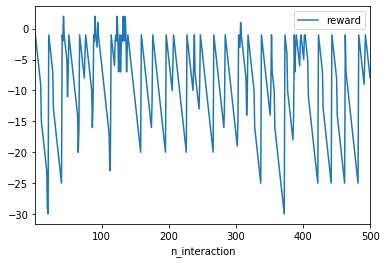

In [357]:
policy = SARSAPolicy(lr=0.1,
                     discount_factor=0.99,
                     observation_space=env.observation_space,
                     n_action=env.action_space.n)
policy = EpsilonGreedy(policy)
stats = run(policy, 500)
print('max:', stats['reward'].max())
stats.plot(x='n_interaction', y='reward')

Create blocks as needed ...

In [358]:
# ใช้ epsilon จะทำให้เจอค่า max reward ที่รวดเร็วกว่า